In [57]:
from qiskit import QuantumCircuit, transpile
import numpy as np
import networkx as nx
from docplex.mp.model import Model
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians
# from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector
# import numpy as np
# from scipy.linalg import logm
# from qiskit.providers.fake_provider import FakeJakartaV2, FakeLagosV2, FakeManilaV2, FakeLimaV2, FakeWashington
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.circuit import ParameterVector
# from qiskit_ibm_provider import IBMProvider
# from braket.aws import AwsDevice

from collections import defaultdict

# from qiskit_braket_provider import AWSBraketBackend
# from qiskit import transpile
# from qiskit_braket_provider import BraketLocalBackend
# from qiskit_braket_provider import AWSBraketProvider

# from braket.aws import AwsSession, AwsQuantumTask

from qiskit_aer.noise import  NoiseModel, QuantumError, pauli_error
from qiskit_aer import AerSimulator, QasmSimulator

# # provider = IBMProvider(instance='ibm-q/open/main')
# # aws_provider = AWSBraketProvider()


In [2]:
def generate_random_graph(num_nodes, connection_percentage, seed=123):
    np.random.seed(seed)
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    
    possible_edges = [(i, j, np.round(np.random.rand(),3)) for i in range(num_nodes) for j in range(i+1, num_nodes)]
    num_edges = int(len(possible_edges) * (connection_percentage))
    
    np.random.shuffle(possible_edges)
    selected_edges = possible_edges[:num_edges]
    G.add_weighted_edges_from(selected_edges)
    
    return G

def QUBO(G):
    # WMaxCut model as a QUBO problem
    mdl = Model('MaxCut')
    num_vertices = G.number_of_nodes()
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(G[i][j]["weight"]*(x[i] * (1 - x[j]) + x[j] * (1 - x[i]))  for i, j in G.edges))
    return mdl

def cost(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] in ["01","10"]:
            obj += G[i][j]["weight"]
    return - obj

def energy(x, hamiltonian):
    obj = 0
    spin = {"1":-1, "0":1}
    for k, v in hamiltonian.items():
        if len(k) == 2:
            obj += v * spin[x[k[0]]] * spin[x[k[1]]]
        elif len(k) == 1:
            obj += v * spin[x[k[0]]]
        else:
            print(k, v)
    return obj

def get_energy(samples, hamiltonian, opt_energy):
    energies = defaultdict(int)
    mean_energy = 0
    shots = sum(samples.values())
    for sample, c in samples.items():
        e = round(energy(sample, hamiltonian), 5)
        energies[e] += c
        mean_energy += e*c
    mean_energy /= shots 
    probability = energies[opt_energy]/shots if opt_energy in energies else 0
    return energies, mean_energy, probability

31 31


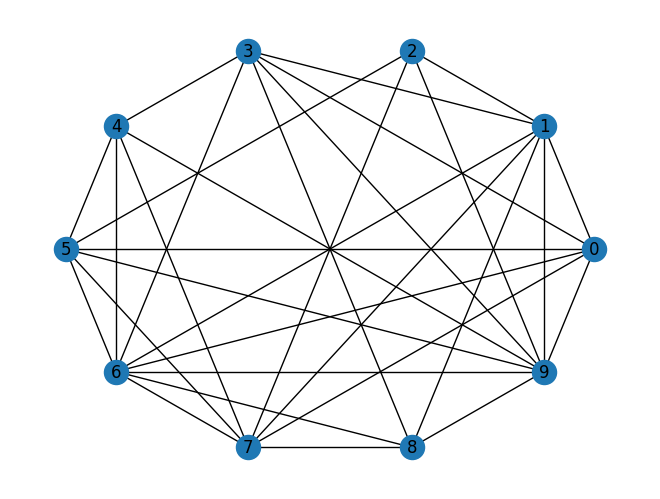

In [3]:
nq = 10
prob = 0.7
G = generate_random_graph(nq, prob)
nx.draw(G, pos=nx.circular_layout(G), with_labels=True)
print(G.number_of_edges(), int(prob * nq * (nq-1)/2))

In [4]:
def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.cx(*qbits)
                qc.rz(2*gammas[ii]*float(value), qbits[1])
                qc.cx(*qbits)
                # qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc

In [5]:
import qiskit_aer.noise as noise
from qiskit_aer.noise import thermal_relaxation_error

def create_noisy_backend(prob_1, prob_2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    # sim_noise = AerSimulator(noise_model=noise_model)
    sim_noise = QasmSimulator(method="density_matrix",
                              noise_model=noise_model)
    return sim_noise

def create_noisy_backend_dephasing(prob_1, prob_2):
    # Depolarizing quantum errors
    error_1 = noise.dephas(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    # sim_noise = AerSimulator(noise_model=noise_model)
    sim_noise = QasmSimulator(method="density_matrix",
                              noise_model=noise_model)
    return sim_noise

def pauli_noisy_backend(prob):
    # Depolarizing quantum errors
    error_gate1 = pauli_error([('X',prob), ('I', 1 - prob)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate2, ['cx'])
    sim_noise = QasmSimulator(method="density_matrix",
                              noise_model=noise_model)
    return sim_noise

def thermal_noise_backend(T1, T2, n_qubits):
    T1s  = n_qubits * [T1 / 1e-9 ] 
    T2s  = n_qubits * [T2 / 1e-9 ]
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n_qubits)])

    # Instruction times (in nanoseconds)
    time_cx = 300

    # QuantumError objects
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                thermal_relaxation_error(t1b, t2b, time_cx))
                for t1a, t2a in zip(T1s, T2s)]
                for t1b, t2b in zip(T1s, T2s)]

    # Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(n_qubits):
        for k in range(n_qubits):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    sim_noise = QasmSimulator(method="density_matrix",
                              noise_model=noise_thermal)
    return sim_noise



# Depolarizing noise percentage of edges

In [45]:
problem_name = "MaxCut"
shots = 10_000
error_1q = 0
delta_beta = 0.5
delta_gamma = 0.5
data = defaultdict(dict)
n_qubits = 8
p = 40
data["p"] = p
data["delta_beta"] = delta_beta
data["delta_gamma"] = delta_gamma
errors = np.logspace(np.log10(1), np.log10(1e-5), num=25)
data["errors"] = errors

probs = [0.2, 0.5, 1.0]
data["probs"] = probs
for prob in probs:
    print(f"-----   prob: {prob} -------")
    prob = float(prob)
    data[prob]["G"] = generate_random_graph(n_qubits, prob)
    betas = np.arange(1, p+1)[::-1] * delta_beta/p
    gammas = np.arange(1, p+1) * delta_gamma/p
    mdl = QUBO(data[prob]["G"])
    ising_hamiltonian = FromDocplex2IsingModel(mdl).ising_model
    max_w = np.max(np.abs(ising_hamiltonian.weights))
    ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
    ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
    data[prob]["ising"] = {tuple(k): v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
    mdl.solve()
    data[prob]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
    data[prob]["opt_cost"] = cost(data[prob]["sol"], data[prob]["G"])
    data[prob]["opt_energy"] = round(energy(data[prob]["sol"], data[prob]["ising"]),5)
    qc = qaoa_circ(data[prob]["ising"], gammas, betas, n_qubits)
    samples = AerSimulator().run(qc, shots=shots).result().get_counts()
    energies, mean_energy, probability = get_energy(samples, data[prob]["ising"], data[prob]["opt_energy"])
    data[prob]["ideal"] = {"probabiliy":probability, "energy":mean_energy}
    data[prob]["noise"] = {}
    for error_2q in errors:
        noisy_backend = create_noisy_backend(error_1q, error_2q)
        fake_samples = noisy_backend.run(qc, shots=shots).result().get_counts()
        energies, mean_energy, probability = get_energy(fake_samples, data[prob]["ising"], data[prob]["opt_energy"])
        data[prob]["noise"][error_2q] = {"probabiliy":probability, "energy":mean_energy}
        print(f"error:{error_2q} probability: {probability}, mean energy: {round(mean_energy,3)}")

np.save(f"./Data/Noise/{n_qubits}_p{p}.npy", data)

-----   prob: 0.2 -------
error:1.0 probability: 0.0299, mean energy: 0.017
error:0.6189658188912606 probability: 0.0299, mean energy: 0.017
error:0.38311868495572876 probability: 0.0328, mean energy: -0.013
error:0.23713737056616552 probability: 0.0355, mean energy: -0.011
error:0.14677992676220694 probability: 0.0308, mean energy: -0.0
error:0.09085175756516867 probability: 0.0305, mean energy: 0.024
error:0.05623413251903491 probability: 0.0346, mean energy: -0.012
error:0.03480700588428409 probability: 0.0308, mean energy: -0.008
error:0.021544346900318832 probability: 0.0388, mean energy: -0.087
error:0.01333521432163324 probability: 0.0637, mean energy: -0.296
error:0.008254041852680182 probability: 0.1409, mean energy: -0.733
error:0.005108969774506924 probability: 0.2684, mean energy: -1.234
error:0.0031622776601683794 probability: 0.4106, mean energy: -1.703
error:0.0019573417814876598 probability: 0.5563, mean energy: -2.119
error:0.0012115276586285877 probability: 0.6818, me

nq: 8 | p: 10 | prob: 0.2 | x: [1.38836318 1.34583784] |  error: 0.000309204333128147
nq: 8 | p: 10 | prob: 0.5 | x: [1.43361154 1.02552377] |  error: 0.0004599965022223523
nq: 8 | p: 10 | prob: 1.0 | x: [1.43540234 0.99932537] |  error: 0.00041873141035592116
nq: 8 | p: 20 | prob: 0.2 | x: [1.43706841 1.3572147 ] |  error: 0.00037637754245061986
nq: 8 | p: 20 | prob: 0.5 | x: [1.44423055 1.113715  ] |  error: 0.00039543940884097283
nq: 8 | p: 20 | prob: 1.0 | x: [1.46135892 1.09714759] |  error: 0.000533462465830957
nq: 8 | p: 40 | prob: 0.2 | x: [1.4115164  1.33053505] |  error: 0.00033276217659291624
nq: 8 | p: 40 | prob: 0.5 | x: [1.42385139 1.09794383] |  error: 0.00042130942869240197
nq: 8 | p: 40 | prob: 1.0 | x: [1.50105217 1.17356674] |  error: 0.0007980829147574361
nq: 10 | p: 10 | prob: 0.2 | x: [1.41392331 1.06446218] |  error: 0.0002599419890592717
nq: 10 | p: 10 | prob: 0.5 | x: [1.42338918 0.68360779] |  error: 0.00041460800507429446
nq: 10 | p: 10 | prob: 1.0 | x: [1.50

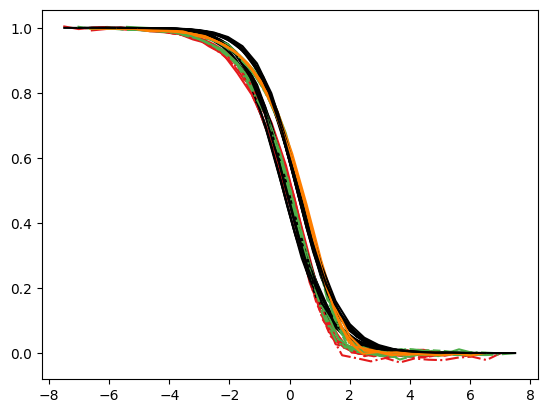

In [122]:
# def sigmoid(x, k, ec):
#     return 1 / (1 + np.exp(k*(x - ec)))

def sigmoid(x, k, A):
    error = np.exp(x)
    return 1 / (1 + A * error**k )

def noise_fun(x, probN, errorT):
    k = x[0]
    A = x[1]
    prob = np.array([sigmoid(error, k, A) for error in errorT])
    error = np.mean((prob - probN)**2)
    return error 


colors = plt.get_cmap("Set1")
fig, ax = plt.subplots()
ps = {8:[10,20,40], 10:[10,20,40], 12:[10]}
nqs = [8, 10, 12]
ks = []
ec = []
for nq in nqs:
    for j, p in enumerate(ps[nq]):
        data = np.load(f"./Data/Noise/{nq}_p{p}.npy", allow_pickle=True).item()
        for i, prob in enumerate(probs):
            probR = data[prob]["noise"][1]["energy"]
            probN = np.array([(data[prob]["noise"][error]["energy"] - probR)/(data[prob]["ideal"]["energy"] - probR) for error in data["errors"] ])
            errorT = np.log(data["errors"]*prob*p*nq*(nq-1)/2)
            x0 = [1.5, 2.6]
            sol = minimize(noise_fun, x0, args=(probN, errorT), method="Nelder-Mead")
            ks.append(sol.x[0])
            ec.append(sol.x[1])
            print(f"nq: {nq} | p: {p} | prob: {prob} | x: {sol.x} |  error: {sol.fun}")

        # ax.plot(data["errors"], len(errors)*[data[prob]["ideal"]["probabiliy"]], color=colors(i), linestyle="--")
            ax.plot(errorT, probN, label=f"prob:{round(prob,2)}", color=colors(nq-8), linestyle=["-", "--", "-."][j])
            ax.plot(errorT, [sigmoid(error, sol.x[0], sol.x[1]) for error in errorT], color="black")
# x = errorT
# plt.plot(x, sigmoid(x, 1.6, -0.7), color="black")
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()


nq: 8 | p: 10 | prob: 0.2 | x: [1.37225575 2.2666691 ] |  error: 0.0003428072077663614
nq: 8 | p: 10 | prob: 0.5 | x: [1.32735707 2.43596321] |  error: 0.0008668070829662899
nq: 8 | p: 10 | prob: 1.0 | x: [1.3983151  2.72240007] |  error: 0.00047721882241802204
nq: 8 | p: 20 | prob: 0.2 | x: [1.42539747 2.48570647] |  error: 0.00036257405634536604
nq: 8 | p: 20 | prob: 0.5 | x: [1.38037852 2.55686399] |  error: 0.0006299819151512043
nq: 8 | p: 20 | prob: 1.0 | x: [1.46549322 3.04122249] |  error: 0.0002649957025277097
nq: 8 | p: 40 | prob: 0.2 | x: [1.394618   2.50951679] |  error: 0.0003104302377413069
nq: 8 | p: 40 | prob: 0.5 | x: [1.46599535 2.66260685] |  error: 0.0002974884708298325
nq: 8 | p: 40 | prob: 1.0 | x: [1.46002025 3.37181798] |  error: 0.0002997918621673356
nq: 10 | p: 10 | prob: 0.2 | x: [1.39843315 2.55778775] |  error: 0.0006403802315145471
nq: 10 | p: 10 | prob: 0.5 | x: [1.44452529 2.21544634] |  error: 0.000593573714111111
nq: 10 | p: 10 | prob: 1.0 | x: [1.42285

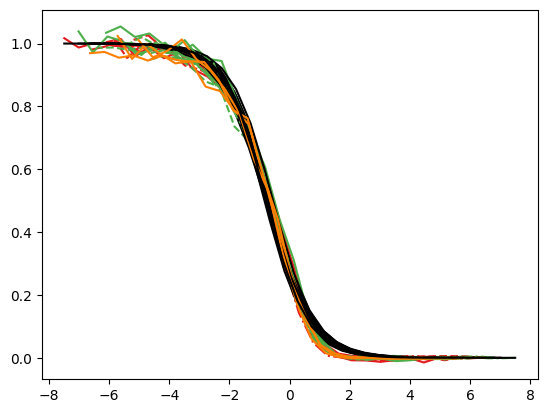

In [208]:
# def sigmoid(x, k, ec):
#     return 1 / (1 + np.exp(k*(x - ec)))

def sigmoid(x, k, A):
    error = np.exp(x)
    return 1 / (1 + A * error**k )

def noise_fun(x, probN, errorT):
    k = x[0]
    A = x[1]
    prob = np.array([sigmoid(error, k, A) for error in errorT])
    error = np.mean((prob - probN)**2)
    # print(f"x: {x}, error: {error}")
    return error 


colors = plt.get_cmap("Set1")
fig, ax = plt.subplots()
ps = {8:[10,20,40], 10:[10,20,40], 12:[10]}
nqs = [8, 10, 12]
ks = []
ec = []
for nq in nqs:
    for j, p in enumerate(ps[nq]):
        data = np.load(f"./Data/Noise/{nq}_p{p}.npy", allow_pickle=True).item()
        for i, prob in enumerate(probs):
            probR = data[prob]["noise"][1]["probabiliy"]
            probN = np.array([(data[prob]["noise"][error]["probabiliy"] - probR)/(data[prob]["ideal"]["probabiliy"] - probR) for error in data["errors"] ])
            errorT = np.log(data["errors"]*prob*p*nq*(nq-1)/2)
            x0 = [1.5, 2.6]
            sol = minimize(noise_fun, x0, args=(probN, errorT), method="Nelder-Mead")
            ks.append(sol.x[0])
            ec.append(sol.x[1])
            print(f"nq: {nq} | p: {p} | prob: {prob} | x: {sol.x} |  error: {sol.fun}")

        # ax.plot(data["errors"], len(errors)*[data[prob]["ideal"]["probabiliy"]], color=colors(i), linestyle="--")
            ax.plot(errorT, probN, label=f"prob:{round(prob,2)}", color=colors(nq-8), linestyle=["-", "--", "-."][j])
            ax.plot(errorT, [sigmoid(error, sol.x[0], sol.x[1]) for error in errorT], color="black")
# x = errorT
# plt.plot(x, sigmoid(x, 1.6, -0.7), color="black")
# ax.set_xscale("log")
# ax.set_yscale("log")
# ax.legend()


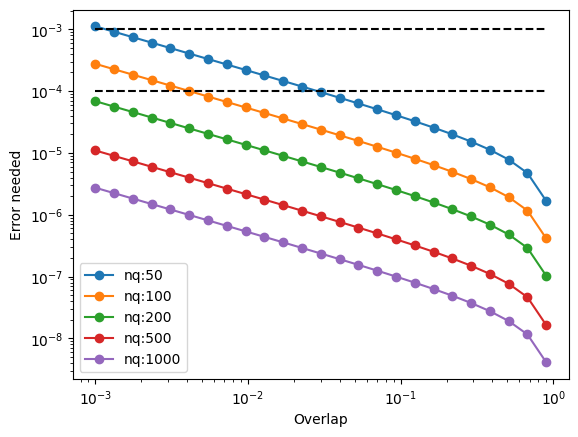

In [162]:
A = 2.7
k = 1.4
p = 100
nq = 100
fig, ax = plt.subplots()

for nq in [50, 100, 200, 500, 1000]:
    # p = nq
    error_needed = lambda peff: 2 * ((1-peff)/(A*peff))**(1/k) / (p*nq*(nq-1)/2)
    overlaps = np.logspace(np.log10(0.001), np.log10(0.9), num=25)
    ax.plot(overlaps, [error_needed(overlap) for overlap in overlaps], marker="o", label=f"nq:{nq}")
ax.plot(overlaps, [1e-3 for overlap in overlaps], linestyle="--", color="black")
ax.plot(overlaps, [1e-4 for overlap in overlaps], linestyle="--", color="black")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Overlap")
ax.set_ylabel("Error needed")
ax.legend()

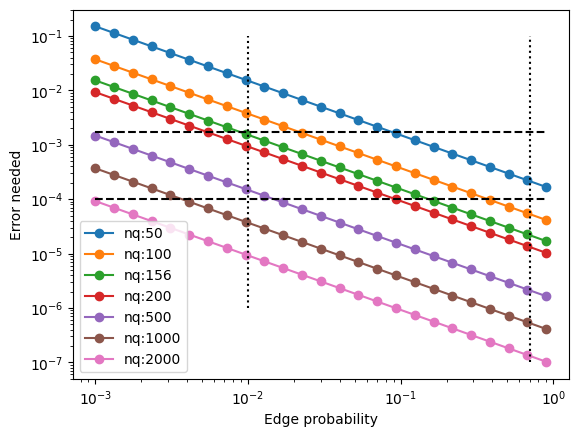

In [218]:
A = 3
k = 1.2
p = 200
nq = 100
fig, ax = plt.subplots()
peff = 0.01
for nq in [50, 100, 156, 200, 500, 1000, 2000]:
    # p = nq
    error_needed = lambda prob: 2 * ((1-peff)/(A*peff))**(1/k) / (prob*p*nq*(nq-1)/2)
    prob = np.logspace(np.log10(0.001), np.log10(0.9), num=25)
    ax.plot(prob, [error_needed(pb) for pb in prob], marker="o", label=f"nq:{nq}")
ax.plot(prob, [1.69e-3 for overlap in prob], linestyle="--", color="black")
ax.plot(prob, [1e-4 for overlap in prob], linestyle="--", color="black")
ax.vlines(0.01, 1e-6, 1e-1, linestyle=":", color="black")
ax.vlines(0.7, 1e-7, 1e-1, linestyle=":", color="black")

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Edge probability")
ax.set_ylabel("Error needed")
ax.legend()

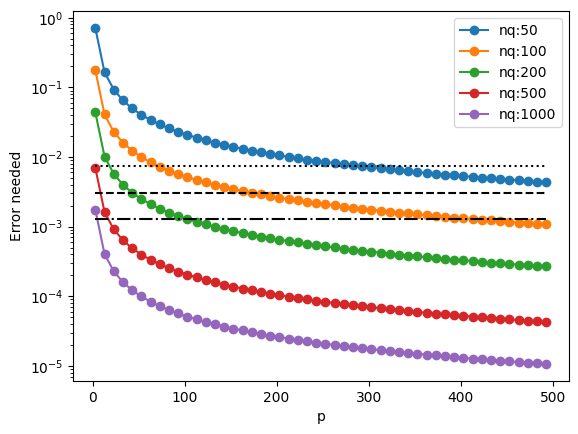

In [223]:
A = 2.7
k = 1.4
p = 100
nq = 100
fig, ax = plt.subplots()
peff = 0.01
prob_edges = 0.01
for nq in [50, 100, 200, 500, 1000]:
    # p = nq
    error_needed = lambda p: 2 * ((1-peff)/(A*peff))**(1/k) / (p*prob_edges*nq*(nq-1)/2)
    ps = np.arange(3, 500, 10)
    ax.plot(ps, [error_needed(p) for p in ps], marker="o", label=f"nq:{nq}")
ax.plot(ps, [2.994e-3 for overlap in ps], linestyle="--", color="black")
ax.plot(ps, [7.358e-3 for overlap in ps], linestyle=":", color="black")
ax.plot(ps, [(1 - 99.87/100) for overlap in ps], linestyle="-.", color="black")
ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("p")
ax.set_ylabel("Error needed")
ax.legend()

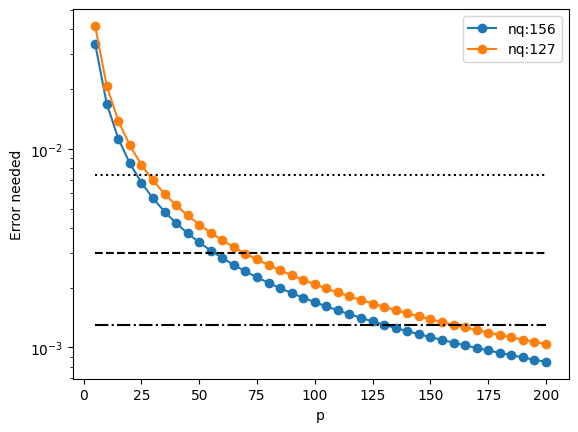

In [195]:
A = 2.7
k = 1.4
p = 100
nq = 100
fig, ax = plt.subplots()
peff = 0.01
nq = 156
prob = 1/(nq/2)

error_needed = lambda p: 2 * ((1-peff)/(A*peff))**(1/k) / (prob*p*nq*(nq-1)/2)
ps = np.arange(5, 201,5)
ax.plot(ps, [error_needed(p) for p in ps], marker="o", label=f"nq:{nq}")
nq = 127
prob = 1/(nq/2)

error_needed = lambda p: 2 * ((1-peff)/(A*peff))**(1/k) / (prob*p*nq*(nq-1)/2)
ps = np.arange(5, 201,5)
ax.plot(ps, [error_needed(p) for p in ps], marker="o", label=f"nq:{nq}")
ax.plot(ps, [2.994e-3 for overlap in ps], linestyle="--", color="black")
ax.plot(ps, [7.358e-3 for overlap in ps], linestyle=":", color="black")
ax.plot(ps, [(1 - 99.87/100) for overlap in ps], linestyle="-.", color="black")
ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("p")
ax.set_ylabel("Error needed")
ax.legend()

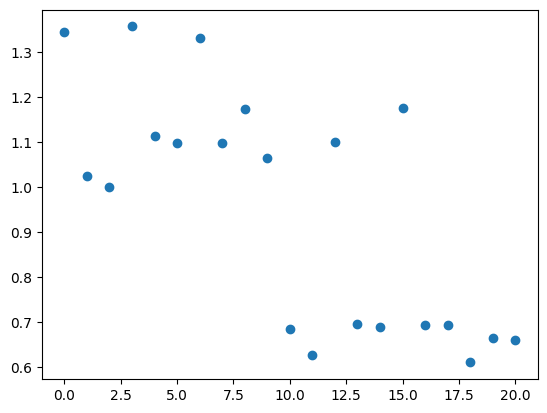

In [119]:
plt.plot(ec, "o")

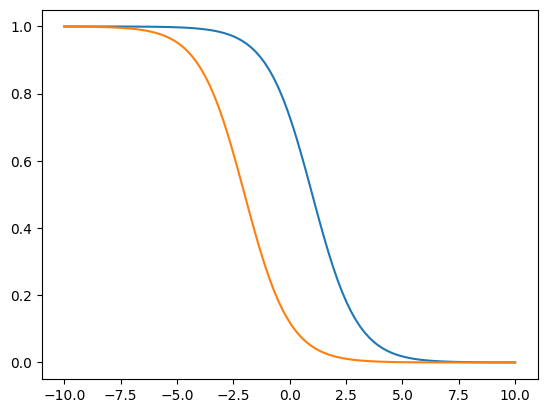

In [79]:
x = np.linspace(-10, 10, 100)
plt.plot(x, sigmid(x, 1, 1))
plt.plot(x, sigmid(x, 1, -2))

In [65]:
ks

[np.float64(-215.60369164723193),
 np.float64(-502.1033613872622),
 np.float64(-1085.841719486083),
 np.float64(-442.35112255052854),
 np.float64(-1046.8955526483273),
 np.float64(-2356.601797659203),
 np.float64(-857.594767299488),
 np.float64(-2180.6369045460942),
 np.float64(-4705.346022263566),
 np.float64(-366.60329940328364),
 np.float64(-846.3760321733319),
 np.float64(-1784.9660724193877),
 np.float64(-714.4638807364583),
 np.float64(-1785.6664717683657),
 np.float64(-3014.3770772311946),
 np.float64(-1487.6484369642533),
 np.float64(-3277.106069781726),
 np.float64(-6142.737169012339),
 np.float64(-483.7070392015791),
 np.float64(-1297.219929039172),
 np.float64(-2736.5396141787232)]

In [69]:
energies

defaultdict(int,
            {np.float64(-0.822): 195,
             np.float64(-0.338): 46,
             np.float64(-0.12): 17,
             np.float64(-1.88): 6250,
             np.float64(-1.662): 3490,
             np.float64(1.28): 2})

In [31]:
problem_name = "MaxCut"
shots = 10_000
prob_1 = 0
cx_errors = [0.02,0.01,0.008, 0.005, 0.001, 0.0001]
ps = [3,4,5,6,7,8,9,10,13,15,20,25,30,40,50,75,100,200]

data = {"ps":ps, "cx_errors":cx_errors}
qubits_list = [10]
for n_qubits in qubits_list:
    print(f"The number of qubits {n_qubits} --------------")
    problem = np.load(f"./Data/{problem_name}.npy", allow_pickle=True).item()["qaoa_sol"][n_qubits][10][0]
    sols = np.array(problem["solutions_bitstrings"])[problem["opt_pos"]]
    ideal = []
    noisy = []
    for p in ps:
        betas = list(np.linspace(1e-3,0.3,p)[::-1])
        gammas = list(np.linspace(1e-3,0.6,p))
        parameters = np.concatenate((betas, gammas))    
        ising = problem["ising_hamiltonian"]
        Hc = {tuple(k):v for k, v in zip(ising.terms,ising.weights)}
        circ = qaoa(Hc, p, ising.n)
        circ = circ.assign_parameters(parameters=parameters)
        ideal_samples = backend["Ideal"].run(circ, shots=shots).result().get_counts()
        prob_circ = sum([ideal_samples[str_sol] for str_sol in np.array(problem["solutions_bitstrings"])[problem["opt_pos"]]])/shots
        errors_list = []
        for prob_2 in cx_errors:
            noisy_backend = create_noisy_backend(prob_1, prob_2)
            fake_samples = noisy_backend.run(circ, shots=shots).result().get_counts()
            prob_circ_fake = sum([(fake_samples[str_sol] if str_sol in fake_samples.keys() else 0) for str_sol in sols])/shots
            errors_list.append(prob_circ_fake)
        ideal.append(prob_circ)
        noisy.append(errors_list)
        # print(f"Probability ideal {prob_circ}  | Probability noise {prob_circ_fake}")

        data[n_qubits] = {"noisy":np.array(noisy), "ideal":np.array(ideal)}
np.save(f"./Data/Noisy_sim/{problem_name}.npy", data)

The number of qubits 6 --------------


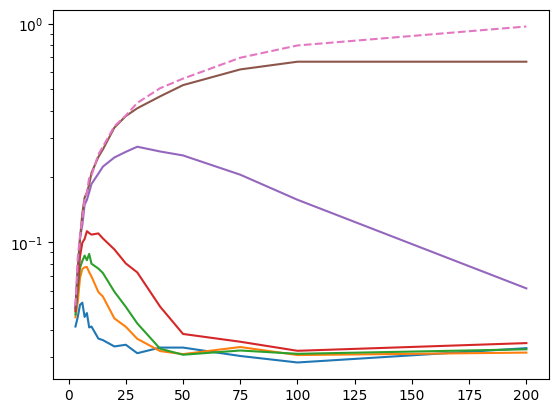

In [32]:
data = np.load(f"./Data/Noisy_sim/{problem_name}.npy", allow_pickle=True).item()
n_qubits = 6
plt.plot(data["ps"], data[n_qubits]["noisy"])
plt.plot(data["ps"], data[n_qubits]["ideal"],"--")
plt.yscale("log")

# Thermal noise

In [47]:
problem_name = "MaxCut"
shots = 10000
prob_1 = 0
T1_list = np.linspace(50, 1000, 10) * 1e-6
ps = [3,4,5,6,7,8,9,10,13,15,20,25,30,40,50,75,100,200]
# ps = [3,4,5,10]
data = {"ps":ps, "cx_errors":cx_errors}
qubits_list = [10]
for n_qubits in qubits_list:
    print(f"The number of qubits {n_qubits} --------------")
    problem = np.load(f"./Data/{problem_name}.npy", allow_pickle=True).item()["qaoa_sol"][n_qubits][10][0]
    sols = np.array(problem["solutions_bitstrings"])[problem["opt_pos"]]
    ideal = []
    noisy = []
    for p in ps:
        print(f"layers --------- {p} ------------")
        betas = list(np.linspace(1e-3,0.3,p)[::-1])
        gammas = list(np.linspace(1e-3,0.6,p))
        parameters = np.concatenate((betas, gammas))    
        ising = problem["ising_hamiltonian"]
        Hc = {tuple(k):v for k, v in zip(ising.terms,ising.weights)}
        circ = qaoa(Hc, p, ising.n)
        circ = circ.assign_parameters(parameters=parameters)
        ideal_samples = backend["Ideal"].run(circ, shots=shots).result().get_counts()
        prob_circ = sum([ideal_samples[str_sol] for str_sol in np.array(problem["solutions_bitstrings"])[problem["opt_pos"]]])/shots
        errors_list = []
        for T1 in T1_list:
            T2 = 1.5 * T1
            noisy_backend = thermal_noise_backend(T1, T2, n_qubits)
            fake_samples = noisy_backend.run(circ, shots=shots).result().get_counts()
            prob_circ_fake = sum([(fake_samples[str_sol] if str_sol in fake_samples.keys() else 0) for str_sol in sols])/shots
            errors_list.append(prob_circ_fake)
        ideal.append(prob_circ)
        noisy.append(errors_list)
        # print(f"Probability ideal {prob_circ}  | Probability noise {prob_circ_fake}")

        data[n_qubits] = {"noisy":np.array(noisy), "ideal":np.array(ideal)}
np.save(f"./Data/Noisy_sim/{problem_name}_thermal.npy", data)

The number of qubits 10 --------------


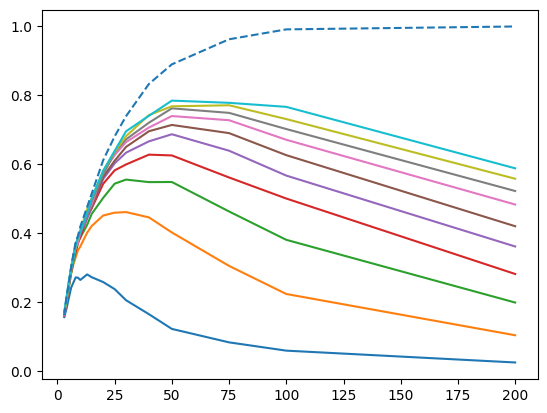

In [45]:
data = np.load(f"./Data/Noisy_sim/{problem_name}_thermal.npy", allow_pickle=True).item()
n_qubits = 4
plt.plot(data["ps"], data[n_qubits]["noisy"])
plt.plot(data["ps"], data[n_qubits]["ideal"],"--")
# plt.xscale("log")

# IBM Brisbane

In [30]:
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.quantum_info import DensityMatrix, partial_trace, Statevector
import numpy as np
from scipy.linalg import logm
from qiskit.providers.fake_provider import FakeJakartaV2, FakeLagosV2, FakeManilaV2, FakeLimaV2, FakeWashington, FakeGuadalupe
import itertools
import matplotlib.pyplot as plt
from qiskit.circuit import ParameterVector
from qiskit_ibm_provider import IBMProvider
from braket.aws import AwsDevice

from collections import defaultdict

from qiskit_braket_provider import AWSBraketBackend
from qiskit import transpile
from qiskit_braket_provider import BraketLocalBackend
from qiskit_braket_provider import AWSBraketProvider

import networkx as nx
from openqaoa.problems import FromDocplex2IsingModel
from docplex.mp.model import Model
import os

from copy import copy

In [25]:
import qiskit_aer.noise as noise
from qiskit_aer import QasmSimulator, AerSimulator

def create_noisy_backend(prob_1, prob_2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    sim_noise = AerSimulator(noise_model=noise_model)
    # sim_noise = QasmSimulator(method="density_matrix",
                            #   noise_model=noise_model)
    return sim_noise

In [26]:
backend = {}
backend["ideal"] = Aer.get_backend("qasm_simulator")
backend["statevector"] = Aer.get_backend("statevector_simulator")


In [27]:
def MaxCut(G):
    # MIS model as a QUBO problem
    mdl = Model('MaxCut')
    num_vertices = G.number_of_nodes()
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum((x[i] * (1 - x[j]) + x[j] * (1 - x[i]))  for (i, j) in G.edges))
    return mdl

def MIS(G, penalty=2):
    # MIS model as a QUBO problem
    mdl = Model('MIS')
    num_vertices = G.number_of_nodes()

    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(x) + penalty * mdl.sum(
        x[i] * x[j] for (i, j) in G.edges
    ))
    return mdl

def WMaxCut(G):
    # MIS model as a QUBO problem
    mdl = Model('MaxCut')
    num_vertices = G.number_of_nodes()
    adjacency_matrix = nx.to_numpy_matrix(G)
    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(adjacency_matrix[i,j]*(x[i] * (1 - x[j]) + x[j] * (1 - x[i]))  for (i, j) in G.edges))
    return mdl

def classical_solution(mdl, string: bool = False, solution_limit = 100):
    """
    Return the classical solution of the maximal independent set problem
    Parameters
    ----------
    string : bool, optional
        If the solution is returned as a string. The default is False.
    Raises
    ------
    ValueError
        A flag if docplex does not find a valid solution.
    Returns
    -------
    solution : Union[str, dict]
        The classical solution of the specific problem as a string or a dict.
    """
    model = mdl.copy()
    decision_variables = [var for var in model.iter_binary_vars()]
    # Define decision variables, constraints, and the objective function
    # ... (Define your problem here) ...

    # Initialize a list to store all optimal solutions
    optimal_solutions = []

    # Initialize a counter to limit the number of solutions (optional)
      # You can set a desired limit
    energy = 0
    while True:
        # Solve the current model
        model.solve()
        if round(model.solution.get_objective_value(), 5) <= energy:
            energy = round(model.solution.get_objective_value(), 5)
        else:
            break
        # Check if a solution is found
        if model.solution is not None:
            # Store the current optimal solution
            optimal_solutions.append("".join(str(round(model.solution.get_value(var))) for var in decision_variables))

            # Add a cut to exclude the current solution
            sol = [var for var in decision_variables if round(model.solution.get_value(var)) == 1] 
            cut = model.sum(sol) <= len(sol) - 1
            model.add_constraint(cut)
        else:
            # No more solutions found
            break

        # You can add additional termination conditions, such as reaching a solution limit

        if len(optimal_solutions) >= solution_limit:
            break
    return optimal_solutions

def qaoa(H_dict, layers, nodes):
    betas = ParameterVector(name=r"$\beta_0$", length=layers)
    gammas = ParameterVector(name=r"$\gamma_0$", length=layers)

    qc = QuantumCircuit(nodes)
    qc.h(range(nodes))
    qc.barrier()
    for p in range(layers):
        permutations = np.arange(nodes) # To decrease the depth of the circuit
        for qbits, value in H_dict.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[p]*round(value,3), qbits[0])
        for jj in range(nodes):
            starting_qubit = jj % 2
            for k in range(starting_qubit, nodes - 1, 2):
                qubit_pair = (permutations[k], permutations[k+1])
                if qubit_pair in H_dict.keys():
#                     qc.rzz(2 * gammas[p] * round(H_dict[qubit_pair],3), *qubit_pair)
                    qc.cx(*qubit_pair)
                    qc.rz(2 * gammas[p] * round(H_dict[qubit_pair],3), qubit_pair[1])
                    qc.cx(*qubit_pair)
                elif qubit_pair[::-1] in H_dict.keys():
                    qubit_pair = qubit_pair[::-1]
                    qc.cx(*qubit_pair)
                    qc.rz(2 * gammas[p] * round(H_dict[qubit_pair],3), qubit_pair[1])
                    qc.cx(*qubit_pair)
#                     qc.rzz(2 * gammas[p] * round(H_dict[qubit_pair],3), *qubit_pair)
                permutations[[k, k+1]] = permutations[[k+1, k]]
        qc.barrier()
        qc.rx(-2*betas[p], range(nodes))
    # qc = qc.reverse_bits()
    qc.measure_all()
    return qc

def optimal_in_samples(samples, opt_sols):
    suma = 0
    for sol in opt_sols:
        if sol in samples.keys():
            suma += samples[sol]
    return suma

def approximation_ratio(cost, optimal):
    return cost/optimal

def hamming_distance(samples, Q, offset, hamming=1):
    change = {"0":"1", "1":"0"}
    new_samples = defaultdict(int)
    nq = len(Q)
    combinations = list(itertools.combinations(range(nq),hamming))
    for string, count in samples.items():
        best_cost = get_cost_QUBO(string, Q, offset)
        best_string = string
        for comb in combinations:
            new_string = "".join((change[i] if n in comb else i) for n, i in enumerate(string))
            new_cost = get_cost_QUBO(new_string, Q, offset)
            if new_cost <= best_cost:
                best_string = new_string
                best_cost = new_cost
                new_samples[new_string] += count
    return new_samples

def from_ising2Q(weights, terms, offset, n_qubits):
    Q = np.zeros((n_qubits, n_qubits))
    max_weight = max(np.abs(weights))
    for w, ij  in zip(weights, terms):
        if len(ij) == 1:
            Q[ij[0], ij[0]] -= 2 * w / max_weight
            offset += w 
        else:
            ij = sorted(ij)
            Q[ij[0], ij[1]] += 4 * w/max_weight
            Q[ij[0], ij[0]] -= 2 * w / max_weight
            Q[ij[1], ij[1]] -= 2 * w / max_weight
            offset += w
    return Q, offset

def get_cost_QUBO(bitstring, Q, offset):
    """Evaluate the cost function"""
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z + offset
    return cost

def get_cost(results, Q, offset):
    cost = []
    for k, v in results.items():
        # cost += [get_cost_QUBO(k, Q)]
        cost += v * [get_cost_QUBO(k, Q, offset)]
    return np.array(cost)


In [28]:
def cost_maxcut(bitstring, weights):
    cost = 0
    for i, j in weights.keys():
        if bitstring[i] + bitstring[j] in ["10","01"]:
            cost += weights[i,j]
    return cost

def objective_MaxCut(samples_dict, G, optimal):
    weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    max_cost = cost_maxcut(optimal, weights)
    results = []
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)
        r  = cost/max_cost
        results.append([cost, r, counts])
    results = np.array(results)
    shots = np.sum(results[:,2])
    rT = np.sum(results[:,0] * results[:,2])/(shots*max_cost)
    return {"results":np.array(results), "G":G, "weights":weights, "max_cut":max_cost, "r":rT}

def mitig(samples, G, hamming=1):
    weights = {(i,j):(G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    change = {"0":"1", "1":"0"}
    new_samples = defaultdict(int)
    nq = G.number_of_nodes()
    combinations = list(itertools.combinations(range(nq),hamming))
    for string, count in samples.items():
        best_cost = cost_maxcut(string, weights)
        best_string = string
        for comb in combinations:
            new_string = "".join((change[i] if n in comb else i) for n, i in enumerate(string))
            new_cost = cost_maxcut(new_string, weights)
            if new_cost >= best_cost:
                best_string = new_string
                best_cost = new_cost
        new_samples[best_string] += count
    return new_samples

def random_samples(num_samples, n_qubits):
    random_samples = defaultdict(int)
    for i in range(num_samples):
        random_samples["".join(str(i) for i in np.random.choice([0,1], n_qubits))] += 1
    return random_samples

In [11]:
problem_name = "MaxCut"
case = np.load(f"./Data/{problem_name}.npy", allow_pickle=True).item()
probs_full = case["qaoa_sol"]
problems = {"sol":{}, "ising":{}, "G":{}}
kk = 0
for n_qubits in [4,10]:
    problems["ising"][n_qubits] = probs_full[n_qubits][10][kk]["ising_hamiltonian"]
    problems["sol"][n_qubits] = [probs_full[n_qubits][10][kk]["solutions_bitstrings"][i] for i in probs_full[n_qubits][10][kk]["opt_pos"]]
    problems["G"][n_qubits] = case["G"][n_qubits][kk]
# np.save("./Data/Noisy_sim/random_problems.npy", problems)

In [48]:
results = np.load(f"./Data/Noisy_sim/{case}_{n_qubits}_depolarizing.npy", allow_pickle=True).item()


In [53]:
# def create_noisy_backend(prob_1, prob_2):
#     # Depolarizing quantum errors
#     p_meas = 1.44e-2
#     p_1q = 1e-4
#     p_gate1 = prob_2
#     error_1 =  pauli_error([('X', p_1q), ('I', 1 - p_1q)])
#     error_2 = noise.depolarizing_error(prob_2, 2)
#     error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
#     error_gate2 = error_gate1.tensor(error_gate1)
#     error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
#     # Add errors to noise model
#     noise_model = noise.NoiseModel()
#     noise_model.add_all_qubit_quantum_error(error_gate1, ['rz', 'sx', 'x'])
#     noise_model.add_all_qubit_quantum_error(error_gate2, ['cx'])
#     noise_model.add_all_qubit_quantum_error(error_meas, "measure")
#     sim_noise = AerSimulator(noise_model=noise_model)
#     return sim_noise

In [29]:
case = ["random", "same_brisbane"][0]
noise_type = ["depolarizing", "pauliX", "real"][1]
n_qubits = 10
try:
    results = np.load(f"./Data/Noisy_sim/{case}_{n_qubits}_depolarizing.npy", allow_pickle=True).item()
except:
    results = {}
    results["samples"] = defaultdict(dict)
if case == "same_brisbane":
    problems = np.load("./Data/Brisbane_MaxCut/problems.npy", allow_pickle=True).item()
elif case == "random":
    problems = np.load("./Data/Noisy_sim/random_problems.npy", allow_pickle=True).item()
shots = 10000
ising_hamiltonian = copy(problems["ising"][n_qubits])
max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
ising_hamiltonian.weights = [round(w/max_w,4) for w in ising_hamiltonian.weights]
ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
Hc = {tuple(k):v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
circuits = []
ps = [3,4,5,6,7,8,9,10,13,15,20,25,30,40,50,75,100,200,500]
# cx_errors = [0.1]
cx_errors = [0.1, 0.05, 0.08, 0.01, 0.005, 0.001, 0.0001, 0.00001]

# ps = [1]
results["optimal"] = problems["sol"][n_qubits] 
results["nq"] = n_qubits
results["shots"] = shots
results["ps"] = ps
results["G"] = problems["G"][n_qubits]
prob = []

for p in ps:
    print(f"Layer: -------  {p} ----------- ")
    betas = list(np.linspace(1e-3, 0.3, p)[::-1])
    gammas = list(np.linspace(1e-3, 0.6, p))
    parameters = np.concatenate((betas,gammas))
    circ = qaoa(Hc, p, ising_hamiltonian.n)
    circ = circ.assign_parameters(parameters=parameters)
    for prob_2 in cx_errors:
        if noise_type == "depolarizing":
            noisy_backend = create_noisy_backend(0, prob_2)
        elif noise_type == "pauliX":
            noisy_backend = pauli_noisy_backend(prob_2)
        elif noise_type == "real":
            noisy_backend = FakeGuadalupe()
        else:
            print(f"Not valid backend {noise_type}!")
            break 
        fake_samples = noisy_backend.run(circ, shots=shots).result().get_counts()
        ideal_samples = backend["ideal"].run(circ, shots=shots).result().get_counts()
        results["samples"][prob_2][p] = {i[::-1]:v for i , v in fake_samples.items()}
    results["samples"]["ideal"][p] = {i[::-1]:v for i , v in ideal_samples.items()}

np.save(f"./Data/Noisy_sim/{case}_{n_qubits}_{noise_type}.npy", results)


Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 
Layer: -------  13 ----------- 
Layer: -------  15 ----------- 
Layer: -------  20 ----------- 
Layer: -------  25 ----------- 
Layer: -------  30 ----------- 
Layer: -------  40 ----------- 
Layer: -------  50 ----------- 
Layer: -------  75 ----------- 
Layer: -------  100 ----------- 
Layer: -------  200 ----------- 
Layer: -------  500 ----------- 


# Real device parameters

In [34]:
case = ["random", "same_brisbane"][0]
noise_type = ["fake"][0]
n_qubits = 10
try:
    results = np.load(f"./Data/Noisy_sim/{case}_{n_qubits}_depolarizing.npy", allow_pickle=True).item()
except:
    results = {}
    results["samples"] = defaultdict(dict)
if case == "same_brisbane":
    problems = np.load("./Data/Brisbane_MaxCut/problems.npy", allow_pickle=True).item()
elif case == "random":
    problems = np.load("./Data/Noisy_sim/random_problems.npy", allow_pickle=True).item()
shots = 10000
ising_hamiltonian = copy(problems["ising"][n_qubits])
max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
ising_hamiltonian.weights = [round(w/max_w,4) for w in ising_hamiltonian.weights]
ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
Hc = {tuple(k):v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
circuits = []
ps = [3,4,5,6,7,8,9,10,13,15,20,25,30,40,50,75,100, 200, 500]
# cx_errors = [0.1]
cx_errors = [0.1, 0.05, 0.08, 0.01, 0.005, 0.001, 0.0001, 0.00001]

# ps = [1]
results["optimal"] = problems["sol"][n_qubits] 
results["nq"] = n_qubits
results["shots"] = shots
results["ps"] = ps
results["G"] = problems["G"][n_qubits]
prob = []
noisy_backend = FakeGuadalupe()
for p in ps:
    print(f"Layer: -------  {p} ----------- ")
    betas = list(np.linspace(1e-3, 0.3, p)[::-1])
    gammas = list(np.linspace(1e-3, 0.6, p))
    parameters = np.concatenate((betas,gammas))
    circ = qaoa(Hc, p, ising_hamiltonian.n)
    circ = circ.assign_parameters(parameters=parameters)
    
    fake_samples = noisy_backend.run(circ, shots=shots).result().get_counts()
    ideal_samples = backend["ideal"].run(circ, shots=shots).result().get_counts()
    results["samples"]["fake"][p] = {i[::-1]:v for i , v in fake_samples.items()}
    results["samples"]["ideal"][p] = {i[::-1]:v for i , v in ideal_samples.items()}

np.save(f"./Data/Noisy_sim/{case}_{n_qubits}_{noise_type}.npy", results)


Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 
Layer: -------  13 ----------- 
Layer: -------  15 ----------- 
Layer: -------  20 ----------- 
Layer: -------  25 ----------- 
Layer: -------  30 ----------- 
Layer: -------  40 ----------- 
Layer: -------  50 ----------- 
Layer: -------  75 ----------- 
Layer: -------  100 ----------- 
Layer: -------  200 ----------- 
Layer: -------  500 ----------- 


# Thermal Noise

In [11]:
case = ["random", "same_brisbane"][1]
n_qubits = 15
results = {"samples":{}, "cost":{}}
if case == "same_brisbane":
    problems = np.load("./Data/Brisbane_MaxCut/problems.npy", allow_pickle=True).item()
elif case == "random":
    problems = np.load("./Data/Noisy_sim/random_problems.npy", allow_pickle=True).item()


shots = 10000
ising_hamiltonian = copy(problems["ising"][n_qubits])
max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
ising_hamiltonian.weights = [round(w/max_w,4) for w in ising_hamiltonian.weights]
ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
Hc = {tuple(k):v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
circuits = []
ps = [3,4,5,6,7,8,9,10,13,15,20,25,30,40,50,75,100, 200, 500]
T1_list = np.linspace(50, 1000, 10) * 1e-6

# ps = [1]
results["optimal"] = problems["sol"][n_qubits] 
results["nq"] = n_qubits
results["shots"] = shots
results["ps"] = ps
results["G"] = problems["G"][n_qubits]
prob = []
results["samples"] = defaultdict(dict)
for p in ps:
    print(f"Layer: -------  {p} ----------- ")
    betas = list(np.linspace(0.3, 1e-3, p))
    gammas = list(np.linspace(1e-3, 0.6, p))
    parameters = np.concatenate((betas,gammas))
    circ = qaoa(Hc, p, ising_hamiltonian.n)
    circ = circ.assign_parameters(parameters=parameters)
    for T1 in T1_list:
        T2 = 1.5 * T1
        noisy_backend = thermal_noise_backend(T1, T2, n_qubits)
        fake_samples = noisy_backend.run(circ, shots=shots).result().get_counts()
        ideal_samples = backend["ideal"].run(circ, shots=shots).result().get_counts()
        results["samples"][T1][p] = {i[::-1]:v for i , v in fake_samples.items()}
    results["samples"]["ideal"][p] = {i[::-1]:v for i , v in ideal_samples.items()}

np.save(f"./Data/Noisy_sim/{case}_{n_qubits}_thermal.npy", results)


Layer: -------  3 ----------- 
Layer: -------  4 ----------- 
Layer: -------  5 ----------- 
Layer: -------  6 ----------- 
Layer: -------  7 ----------- 
Layer: -------  8 ----------- 
Layer: -------  9 ----------- 
Layer: -------  10 ----------- 
Layer: -------  13 ----------- 
Layer: -------  15 ----------- 
Layer: -------  20 ----------- 
Layer: -------  25 ----------- 
Layer: -------  30 ----------- 
Layer: -------  40 ----------- 
Layer: -------  50 ----------- 
Layer: -------  75 ----------- 
Layer: -------  100 ----------- 
Layer: -------  200 ----------- 
Layer: -------  500 ----------- 


In [45]:
results.keys()

dict_keys(['probs', 'r', 'ps'])

In [60]:
probabilities = {}
r = {}
case = ["random", "same_brisbane"][0]
list_qubits = [10]
name = ["raw","mitig"][1]
noise_type = ["depolarizing", "thermal", "pauliX", "fake"][3]
for n_qubits in list_qubits:
    results = np.load(f"./Data/Noisy_sim/{case}_{n_qubits}_{noise_type}.npy", allow_pickle=True).item()
    probabilities[n_qubits] = {}
    r[n_qubits] = {}
    for section in results["samples"].keys():
        probs = []
        rs = []    
        for p in results["samples"][section].keys():
            samples = results["samples"][section][p]
            if name == "mitig":
                samples = mitig(samples, results["G"])
            probs.append(sum([(samples[i] if i in samples.keys() else 0) for i in results["optimal"]])/results["shots"])
            rs.append(objective_MaxCut(samples, results["G"], results["optimal"][0])["r"])
        probabilities[n_qubits][section] = probs
        r[n_qubits][section] = rs

np.save(f"./Data/Noisy_sim/probabilities_{case}_{name}_{noise_type}.npy", {"probs":probabilities, "r":r, "ps":results["ps"]})


In [61]:
name = "raw"
noise_type = "fake"
case = ["random", "same_brisbane"][0]
results_1 = np.load(f"./Data/Noisy_sim/probabilities_{case}_{name}_{noise_type}.npy", allow_pickle=True).item()
name = "mitig"
case = ["random", "same_brisbane"][0]
results = np.load(f"./Data/Noisy_sim/probabilities_{case}_{name}_{noise_type}.npy", allow_pickle=True).item()

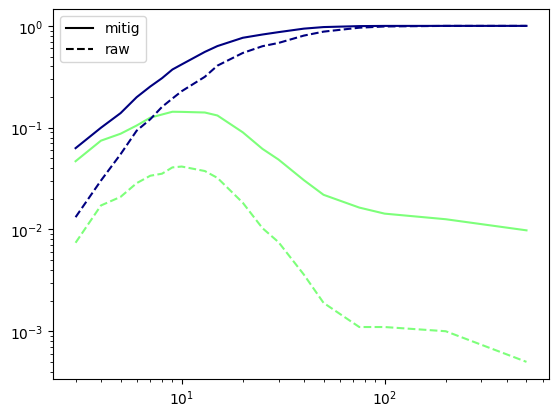

In [62]:
colors = plt.get_cmap("jet")
n_qubits = 10
for n, i in enumerate(results["probs"][n_qubits]):
    plt.plot(results["ps"], results["probs"][n_qubits][i], color=colors(n/len(results["probs"][n_qubits])))
for n, i in enumerate(results_1["probs"][n_qubits]):    
    plt.plot(results_1["ps"], results_1["probs"][n_qubits][i], linestyle="--", color=colors(n/len(results_1["probs"][n_qubits])))

plt.plot([],[],label="mitig", color="black")
plt.plot([],[],linestyle="--", label="raw", color="black")

plt.legend()
plt.yscale("log")
plt.xscale("log")

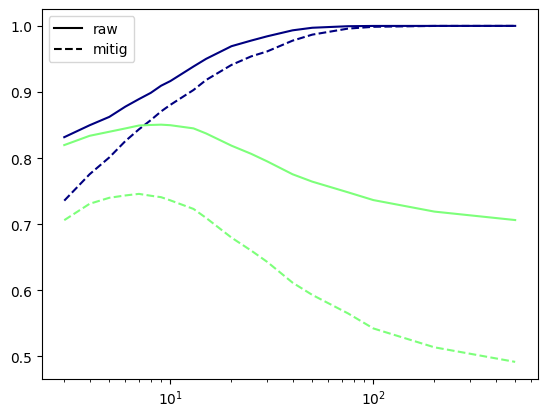

In [63]:
colors = plt.get_cmap("jet")
n_qubits = 10
for n, i in enumerate(results["r"][n_qubits]):
    plt.plot(results["ps"], results["r"][n_qubits][i], color=colors(n/len(results["probs"][n_qubits])))
    plt.plot(results["ps"], results_1["r"][n_qubits][i], linestyle="--", color=colors(n/len(results_1["probs"][n_qubits])))
    # plt.plot(results["ps"], r[10][i], label=i, linestyle="--")

plt.plot([],[],label="raw", color="black")
plt.plot([],[],linestyle="--", label="mitig", color="black")

plt.legend()
plt.xscale("log")

# Real device parameters